

Two datasets used:
* Raw EEG Data
* Raw Spectrogram Data (NAs filled by 0)

Potential dataset
* Spectrogram data built by EEGs (<a href=https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms/data)>Spectrogram Data Built by Chris Deotte</a>)

In [1]:
import pandas as pd
import numpy as np
from scipy.special import kl_div
from sklearn.model_selection import GroupKFold
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class ReadData():
    def __init__(self, is_train = True):
        self.is_train = is_train
    
    def _read_data(self, data_type, file_id):
        if self.is_train:
            PATH = f"/kaggle/input/hms-harmful-brain-activity-classification/train_{data_type}/{file_id}.parquet"
        else:
            PATH = f"/kaggle/input/hms-harmful-brain-activity-classification/test_{data_type}/{file_id}.parquet"
        
        return pd.read_parquet(PATH)
        
    def read_spectrogram_data(self, spectrogram_id):
        return self._read_data('spectrograms', spectrogram_id).set_index('time')
    
    def read_eeg_data(self, eeg_id) -> pd.DataFrame:
        return self._read_data('eegs', eeg_id)
    
    def read_train_data(self):
        return pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")

In [3]:
class FeatureEngineerData():
    def __init__(self, df, row_id, dataset, timeframe):
        self.df = df
        self.row_id = row_id
        self.dataset = dataset
        self.timeframe = timeframe
    
    def get_mean(self) -> pd.DataFrame:
        return (self.df
                .mean()
                .reset_index()
                .set_axis(['var', 'mean'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='mean', index='row_id')
                .add_prefix('mean_')
        )
     
    def get_max(self) -> pd.DataFrame:
        return (self.df
                .max()
                .reset_index()
                .set_axis(['var', 'max'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='max', index='row_id')
                .add_prefix('max_')
        )
    
    def get_min(self) -> pd.DataFrame:
        return (self.df
                .max()
                .reset_index()
                .set_axis(['var', 'min'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='min', index='row_id')
                .add_prefix('min_')
        )   
    
    def get_corr(self) -> pd.DataFrame:
        '''
        Returns the correlation of an eeg file
        '''
        def apply_mask(df):
            mask = np.triu(np.ones_like(df, dtype=bool))
            return df.where(mask).unstack().dropna()

        return (self.df
             .corr()
             .pipe(apply_mask)
             .reset_index()
             .set_axis(['var_1', 'var_2', 'corr'], axis=1)
             .query("var_1 != var_2")
             .assign(
                 row_id = self.row_id,
                 label = lambda x: x.var_1 + "_" + x.var_2
             )
                .pivot(columns='label', values='corr', index='row_id')
                .add_prefix('cor_')
        )
    
    def filter_spectrogram_corr(self, corr_df) -> pd.DataFrame:
        '''
        Returns a dataframe with only the correlation across the same frequency
        '''
        return corr_df[[col for col in corr_df.columns if col.split('_')[2] == col.split('_')[4]]]
    
    def get_std(self) -> pd.DataFrame:
        return (self.df
                .std()
                .reset_index()
                .set_axis(['var', 'std'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='std', index='row_id')
                .add_prefix('std_')
        )
    
    def get_range(self) -> pd.DataFrame:
        return (
            self.df
            .max()
            .sub(self.df.min())
            .reset_index()
            .set_axis(['var', 'range'], axis=1)
            .assign(row_id = self.row_id)
            .pivot(columns='var', values='range', index='row_id')
            .add_prefix('range_')
        )
    
    def get_features(self) -> pd.DataFrame:
        
        if self.dataset == 'eeg':
            return (pd.concat([
                self.get_mean(),
                self.get_std(),
                self.get_max(),
                self.get_min(),
                self.get_corr()
            ], axis=1).add_prefix(f"{self.dataset}_{self.timeframe}_"))
        else:
            return (pd.concat([
                self.get_mean(),
                self.get_std(),
                self.get_max(),
                self.get_min()
                #self.filter_spectrogram_corr(self.get_corr())
            ], axis=1).add_prefix(f"{self.dataset}_{self.timeframe}_"))

In [4]:
def kld_score(solution, submission):
    '''
    Calculate the average KL divergence score.
    Ignores the "row id" assumed in the first column.
    '''
    sumsum = 0.0
    # Go through the probabilities
    for prob_col in solution.columns.values:
        sumsum += np.nansum(-1.0*solution[prob_col] *
                        np.log(submission[prob_col] / solution[prob_col]))
    return sumsum/(len(solution))


In [5]:
rd = ReadData()

train_df = rd.read_train_data()
train_df['left_eeg_index'] = train_df['eeg_label_offset_seconds'].multiply(200).astype('int')
train_df['right_eeg_index'] = train_df['eeg_label_offset_seconds'].add(50).multiply(200).astype('int')

In [6]:
df = pd.DataFrame()
for index, row in tqdm(train_df.query("eeg_sub_id == 0").iterrows()):
    
    # Spectrogram files
    total_spec = (rd.read_spectrogram_data(row['spectrogram_id'])
                  .loc[row['spectrogram_label_offset_seconds']:row['spectrogram_label_offset_seconds']+600]
                  .fillna(0)
                 )
    
    middle = (row['spectrogram_label_offset_seconds']+(600+row['spectrogram_label_offset_seconds']))/2
    spec_1m = total_spec.loc[middle-30:middle+30]
    spec_10s = total_spec.loc[middle-5:middle+5]
    spec_30s = total_spec.loc[middle-15:middle+15]
    
    # EEG files
    total_eeg = rd.read_eeg_data(row['eeg_id']).iloc[row['left_eeg_index']:row['right_eeg_index']]
    middle_eeg = total_eeg.iloc[4500:5500]
    
    
    row_id = row['label_id']
    
    spec_total = FeatureEngineerData(total_spec, row_id, 'spec', 'total').get_features()
    spec_1m = FeatureEngineerData(spec_1m, row_id, 'spec', '60s').get_features()
    spec_10s = FeatureEngineerData(spec_10s, row_id, 'spec', '10s').get_features()
    spec_30s = FeatureEngineerData(spec_30s, row_id, 'spec', '30s').get_features()

    eeg_total = FeatureEngineerData(total_eeg, row_id, 'eeg', 'total').get_features()
    eeg_10s = FeatureEngineerData(middle_eeg, row_id, 'eeg', '10s').get_features()
    
    row_data = pd.concat([
        spec_total,
        spec_1m,
        spec_10s,
        spec_30s,
        eeg_total,
        eeg_10s
    ], axis=1)

    
    df = pd.concat([
        df,
        row_data
    ])


0it [00:00, ?it/s]

In [7]:
#df = pd.read_parquet("/kaggle/working/training_data.parquet")

In [8]:
df = df.sample(frac=1, random_state=42)
df.index.name = 'row_id'

X = df.reset_index(drop=True)#.filter(regex='cor|std|range')
y_prob = df.reset_index().rename(columns={'row_id':'label_id'}).merge(train_df).filter(like = '_vote')
y_prob = y_prob.divide(y_prob.sum(axis=1), axis=0)

TARGETS = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}
y = df.merge(train_df, left_on='row_id', right_on='label_id')['expert_consensus'].map(TARGETS)

patient_id = train_df.query("eeg_sub_id == 0").iloc[0:len(df)].groupby('eeg_id')['patient_id'].first()

In [9]:
folds = GroupKFold(n_splits=5)

for fold, (train_index, valid_index) in enumerate(folds.split(X, y, patient_id)): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index] 
    X_val, y_val = X.iloc[valid_index], y.iloc[valid_index] 

    print('Training: XGB...')
    xgb_mod = xgb.XGBClassifier(
        tree_method="hist", 
        n_estimators = 1000,
        learning_rate=0.1,
        colsample_bytree=1,
        max_depth = 7,
        verbosity=1,
        objective='multi:softmax',
        early_stopping_rounds=20,
        n_jobs=-1
    )
    xgb_mod.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    break

Training: XGB...
[0]	validation_0-mlogloss:1.68976
[1]	validation_0-mlogloss:1.60631
[2]	validation_0-mlogloss:1.53749
[3]	validation_0-mlogloss:1.47883
[4]	validation_0-mlogloss:1.42668
[5]	validation_0-mlogloss:1.38002
[6]	validation_0-mlogloss:1.33830
[7]	validation_0-mlogloss:1.30186
[8]	validation_0-mlogloss:1.26844
[9]	validation_0-mlogloss:1.23798
[10]	validation_0-mlogloss:1.21022
[11]	validation_0-mlogloss:1.18452
[12]	validation_0-mlogloss:1.16045
[13]	validation_0-mlogloss:1.13954
[14]	validation_0-mlogloss:1.11973
[15]	validation_0-mlogloss:1.10102
[16]	validation_0-mlogloss:1.08552
[17]	validation_0-mlogloss:1.07067
[18]	validation_0-mlogloss:1.05694
[19]	validation_0-mlogloss:1.04421
[20]	validation_0-mlogloss:1.03259
[21]	validation_0-mlogloss:1.02161
[22]	validation_0-mlogloss:1.01024
[23]	validation_0-mlogloss:1.00002
[24]	validation_0-mlogloss:0.99151
[25]	validation_0-mlogloss:0.98300
[26]	validation_0-mlogloss:0.97438
[27]	validation_0-mlogloss:0.96656
[28]	validati

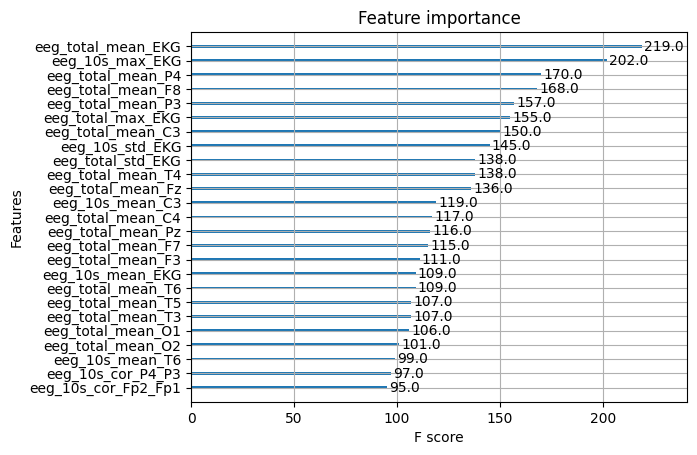

In [10]:
xgb.plot_importance(xgb_mod, max_num_features=25)
plt.show()